In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [3]:
df=pd.read_csv("C:/Users/HP/Downloads/AEP_hourly.csv",index_col=[0], parse_dates=[0]) # We set the index column and know it has dates

df.head(15)

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
2004-12-31 06:00:00,13038.0
2004-12-31 07:00:00,13692.0
2004-12-31 08:00:00,14297.0
2004-12-31 09:00:00,14719.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [5]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


<Axes: xlabel='Datetime'>

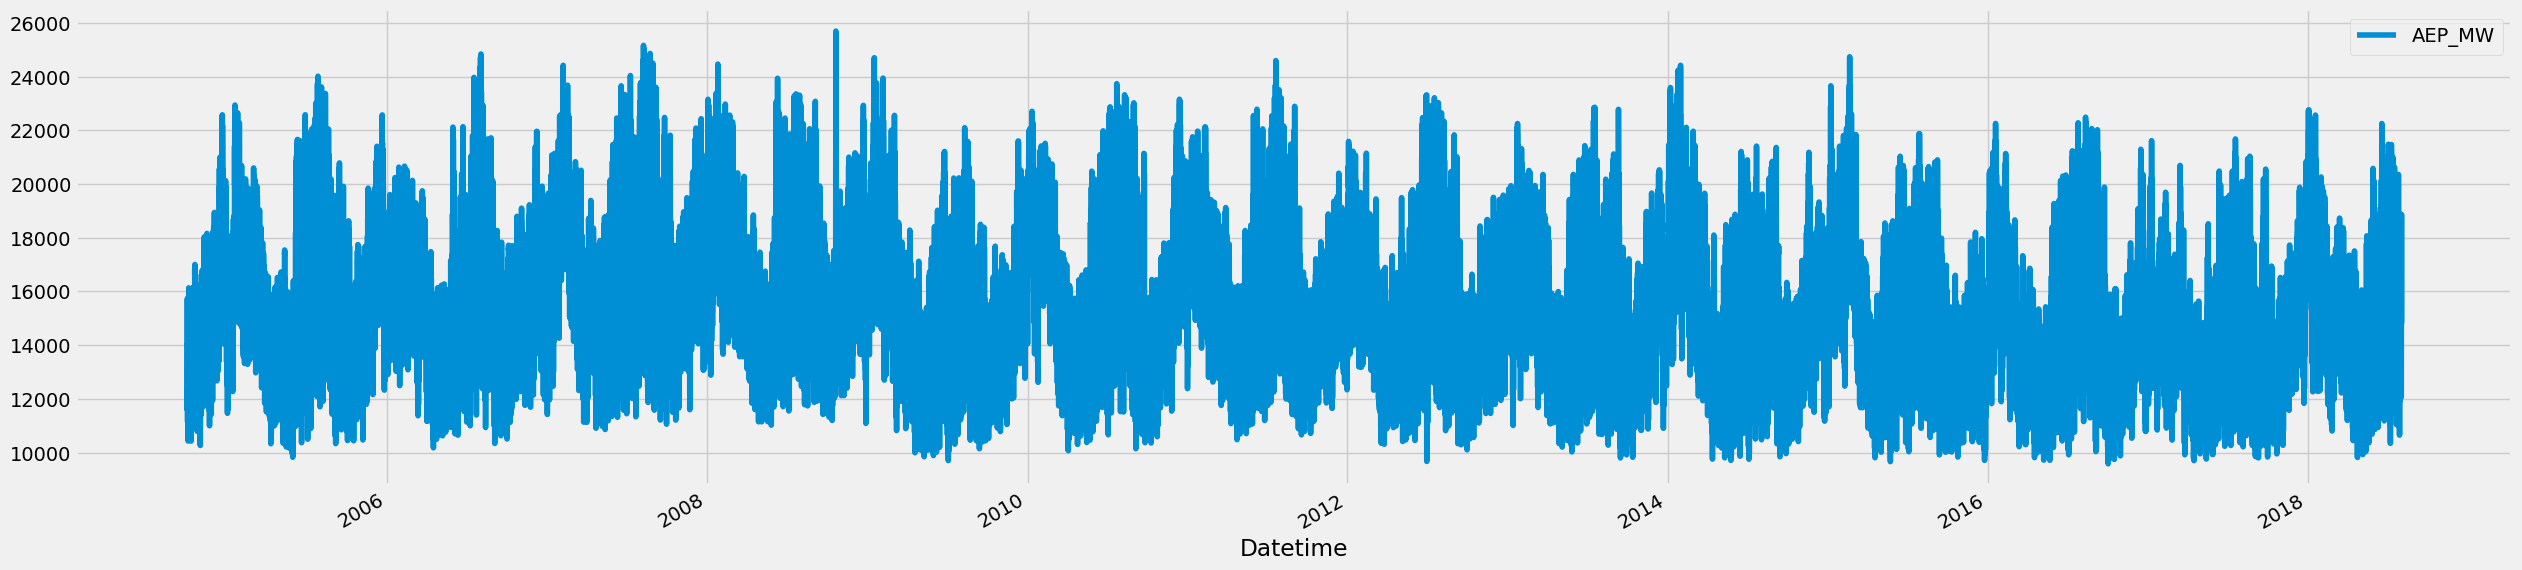

In [6]:
df.plot(figsize=(28,7))

<Axes: xlabel='Datetime'>

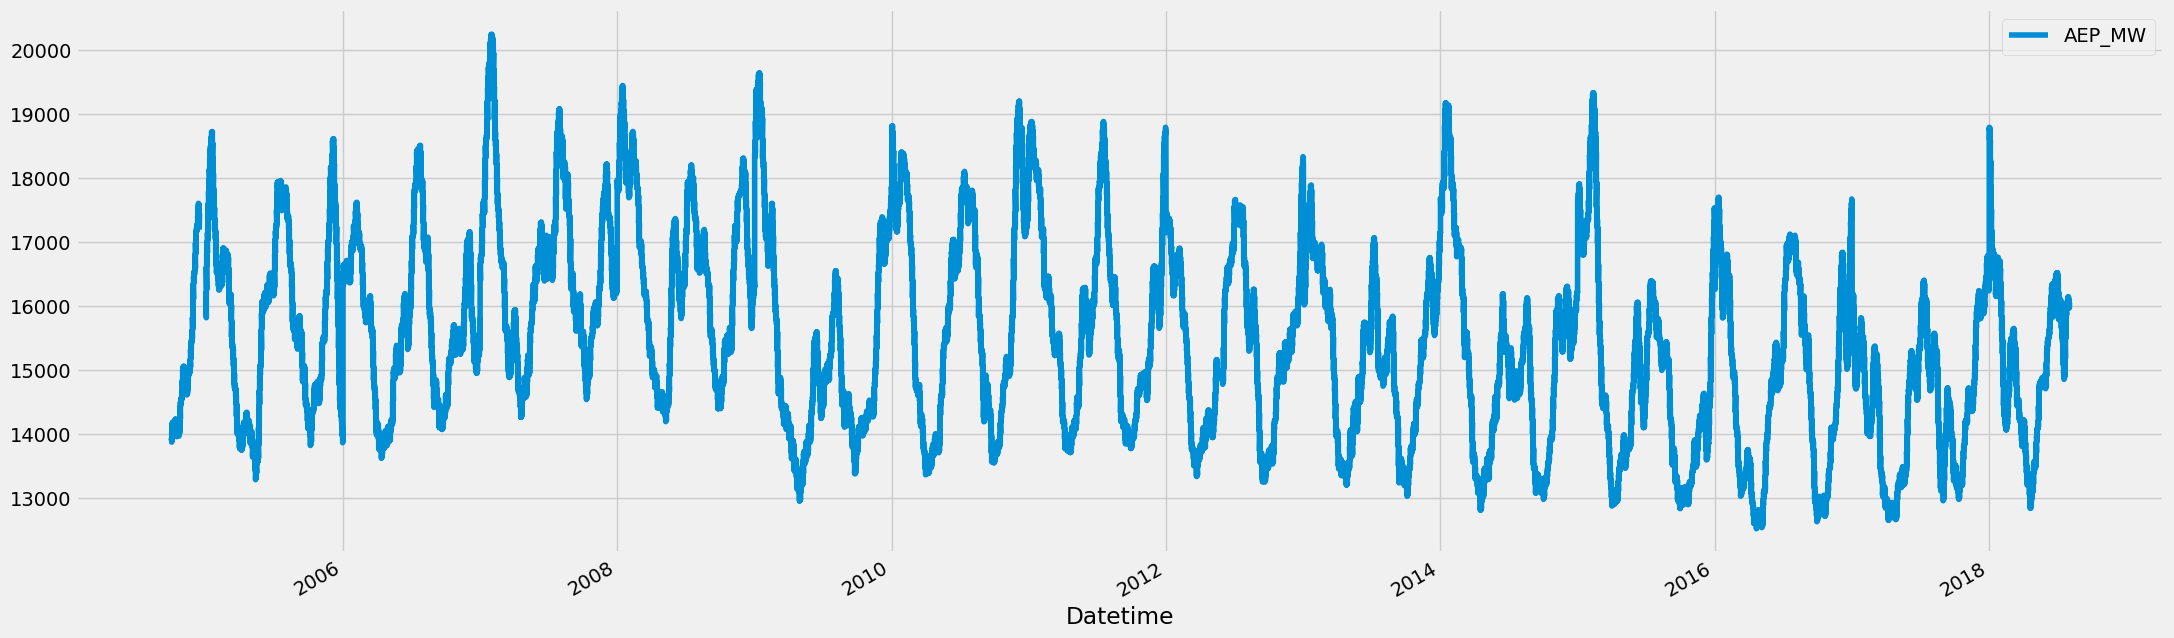

In [7]:
df[['AEP_MW']].rolling(411).mean().plot(figsize=(24,8))

In [8]:
import scipy.stats
import pylab


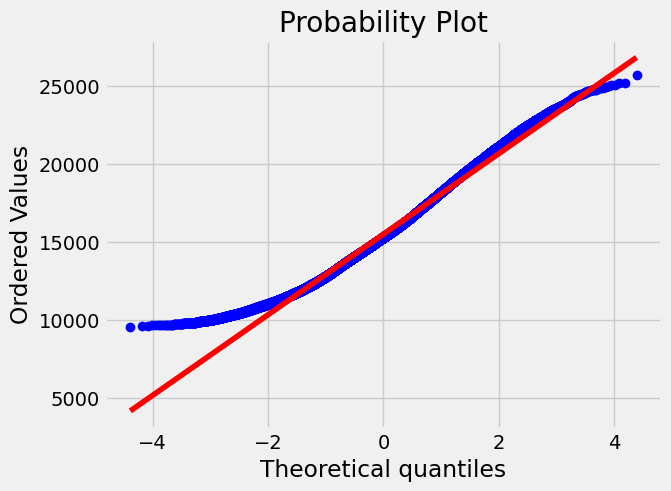

In [9]:
scipy.stats.probplot(df.AEP_MW,plot = pylab)
pylab.show()

In [10]:
sts.adfuller(df)

(-16.446812104686664,
 2.3990113240023705e-29,
 71,
 121201,
 {'1%': -3.430403955318047,
  '5%': -2.8615638474512295,
  '10%': -2.566782693155802},
 1743112.757904275)

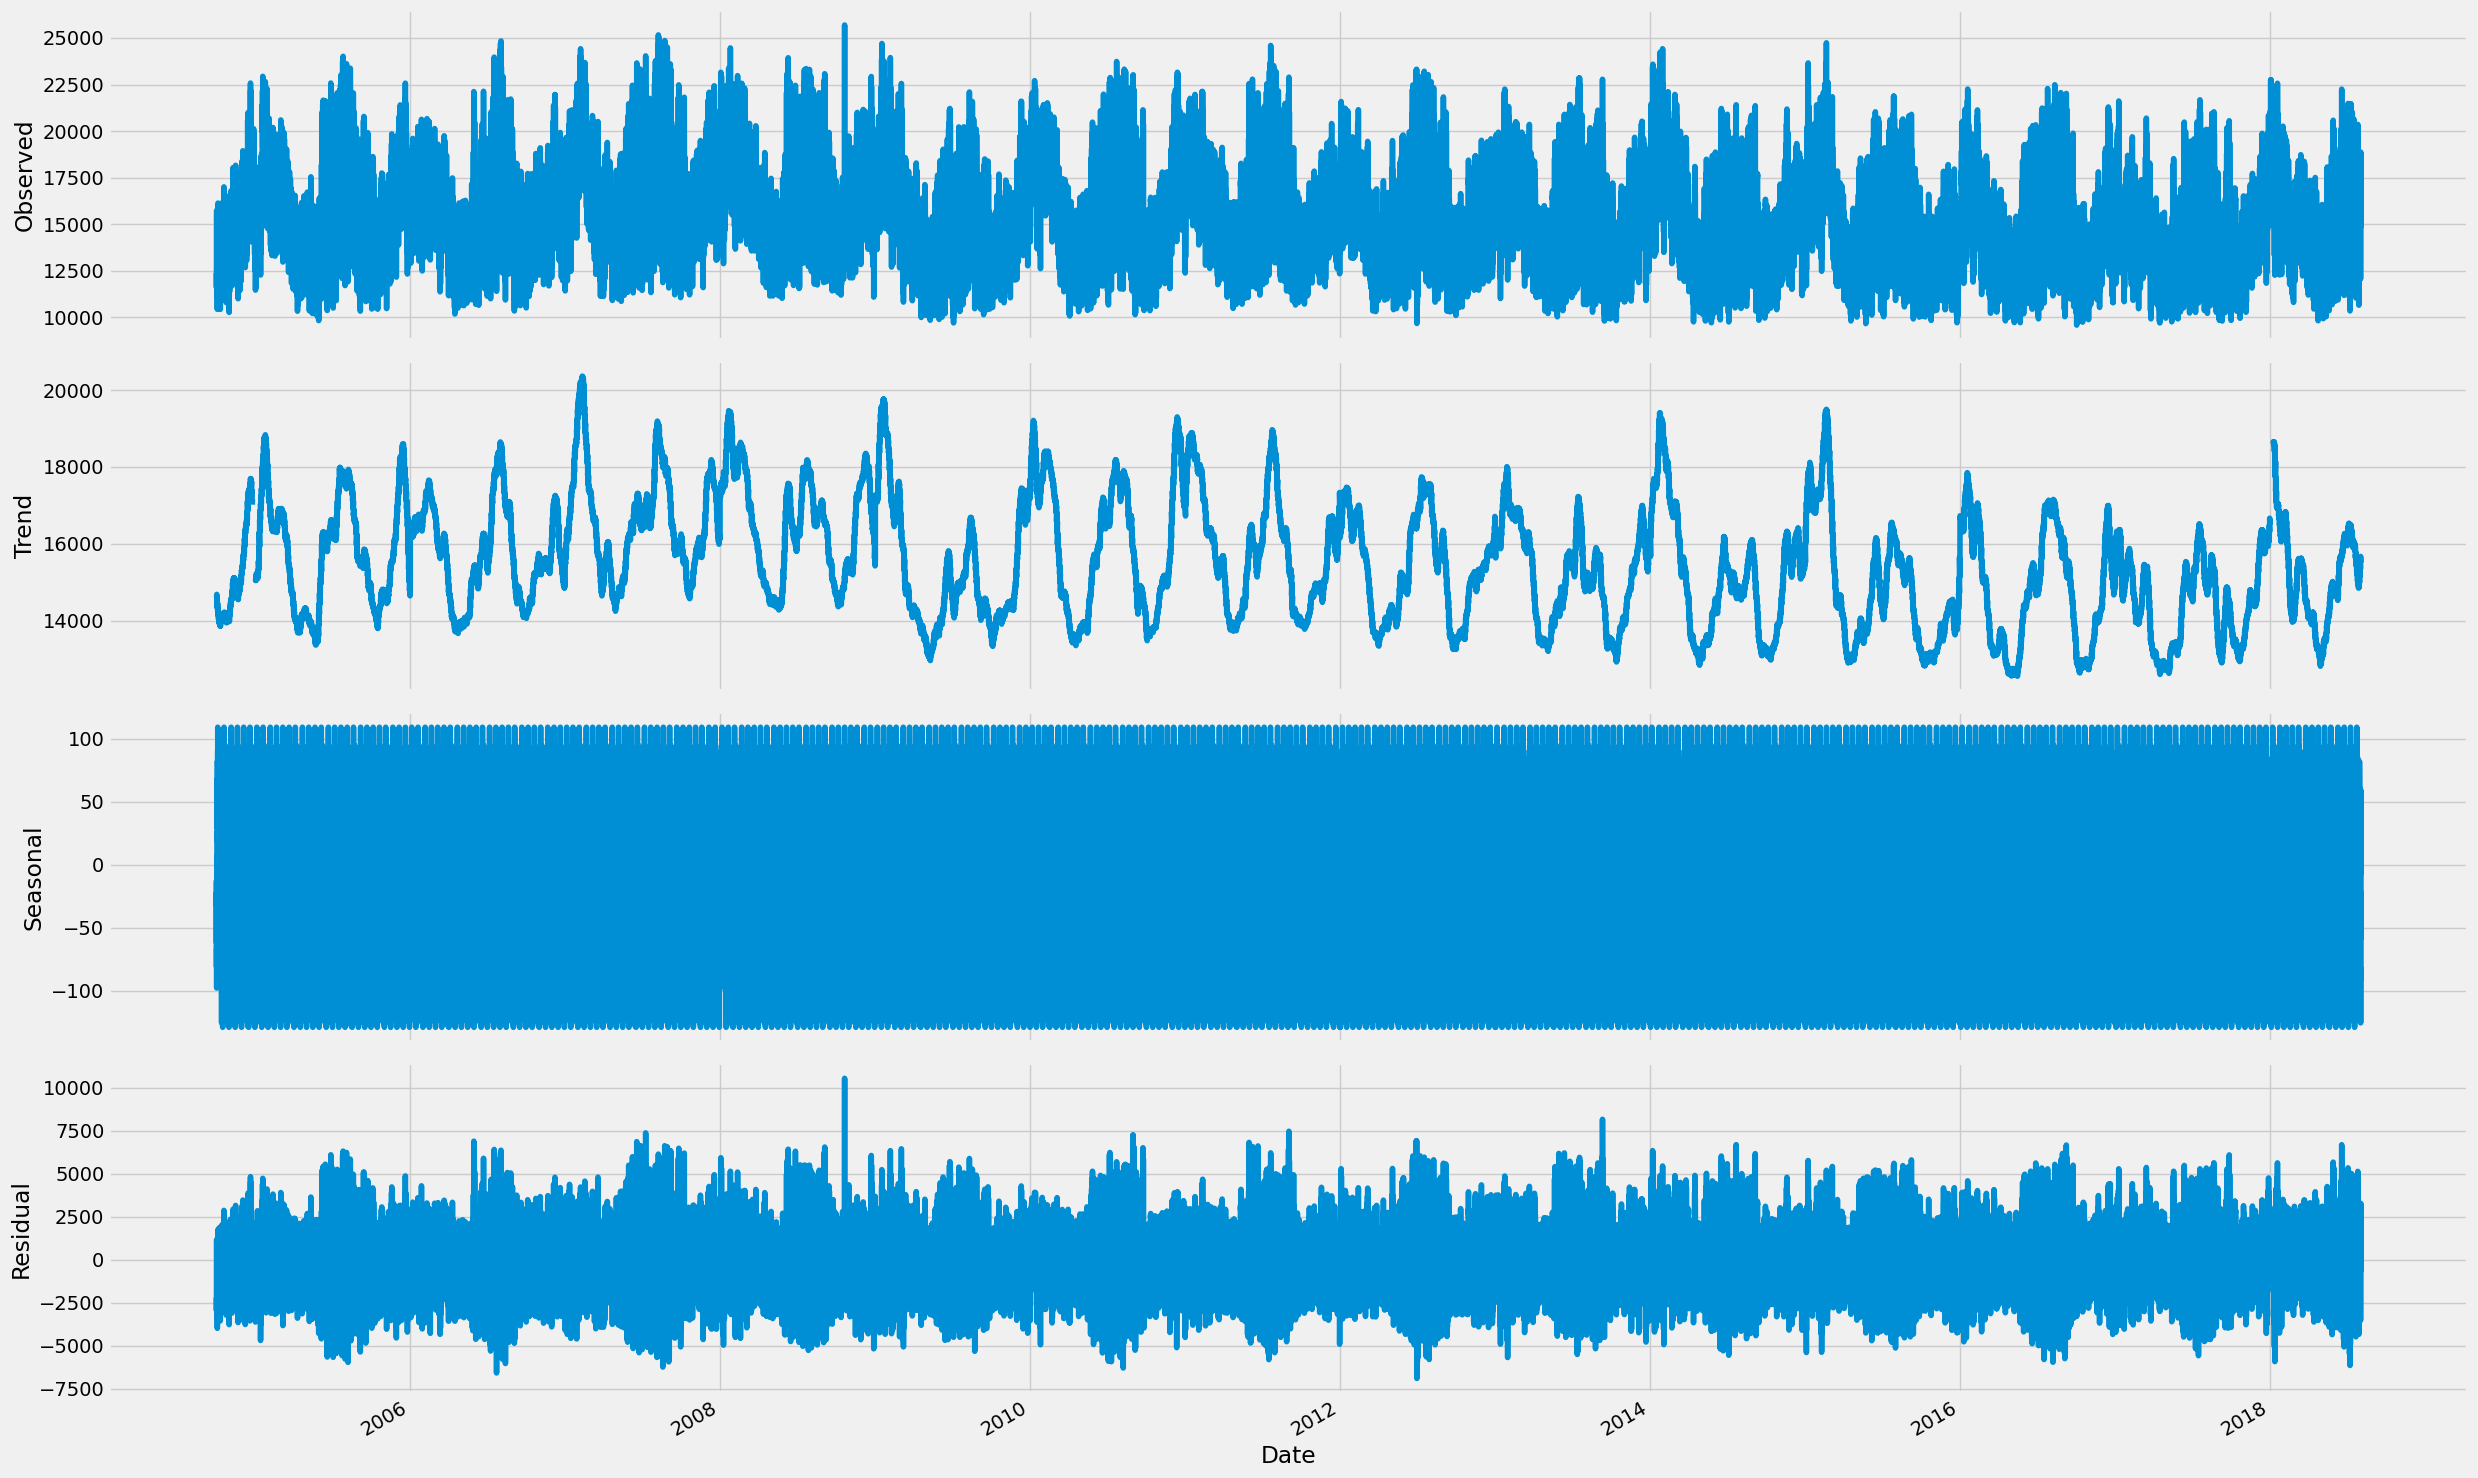

In [11]:
result = seasonal_decompose(df['AEP_MW'], model='additive', period=365)  # Set period to fit your data frequency

# Create a figure with a specified size
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(25, 15), sharex=True)

# Plot the decomposed components
result.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')

plt.tight_layout()
plt.show()

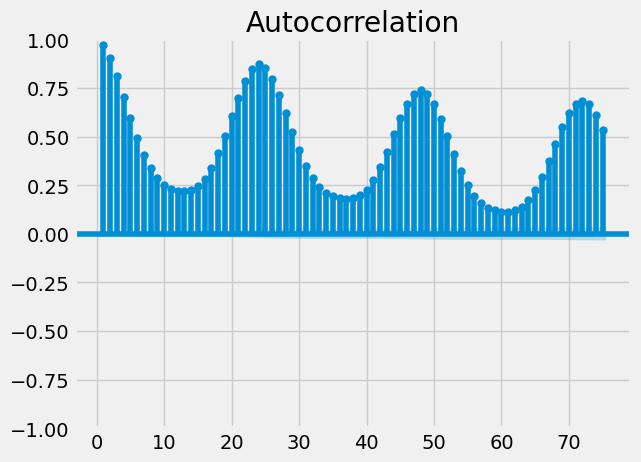

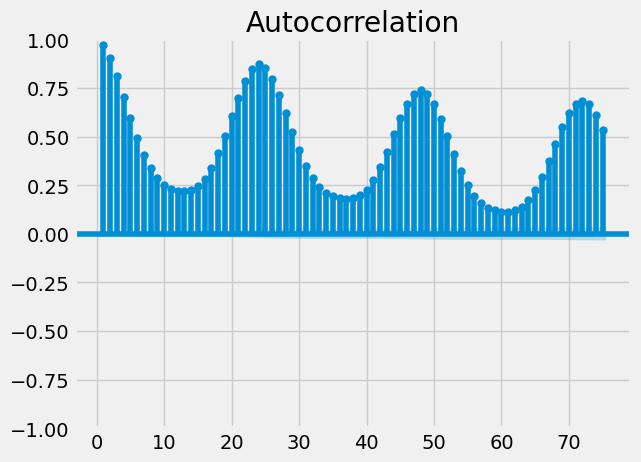

In [12]:
sgt.plot_acf(df['AEP_MW'],lags=75,zero=False)

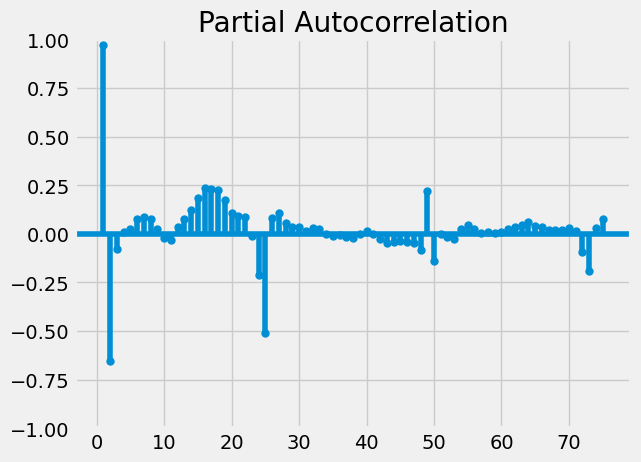

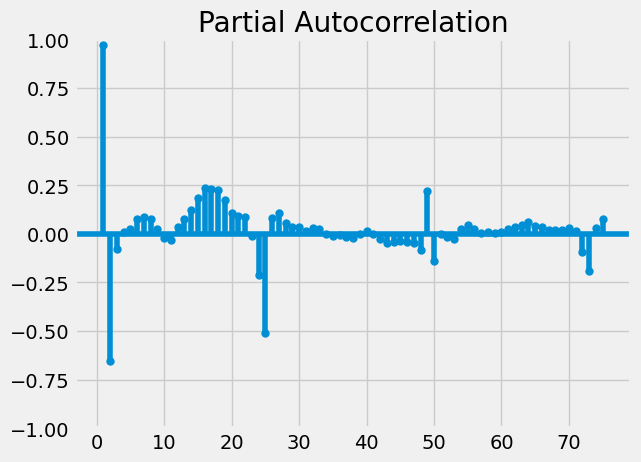

In [13]:
sgt.plot_pacf(df,lags=75,zero=False,method='ols')

In [18]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
#     df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='AEP_MW')

features_and_target = pd.concat([X, y], axis=1)

In [19]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,AEP_MW
Datetime,,,,,,,,
2004-12-31 01:00:00,1,4,4,12,2004,366,31,13478.0
2004-12-31 02:00:00,2,4,4,12,2004,366,31,12865.0
2004-12-31 03:00:00,3,4,4,12,2004,366,31,12577.0
2004-12-31 04:00:00,4,4,4,12,2004,366,31,12517.0
2004-12-31 05:00:00,5,4,4,12,2004,366,31,12670.0


D:\Anaconda_3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


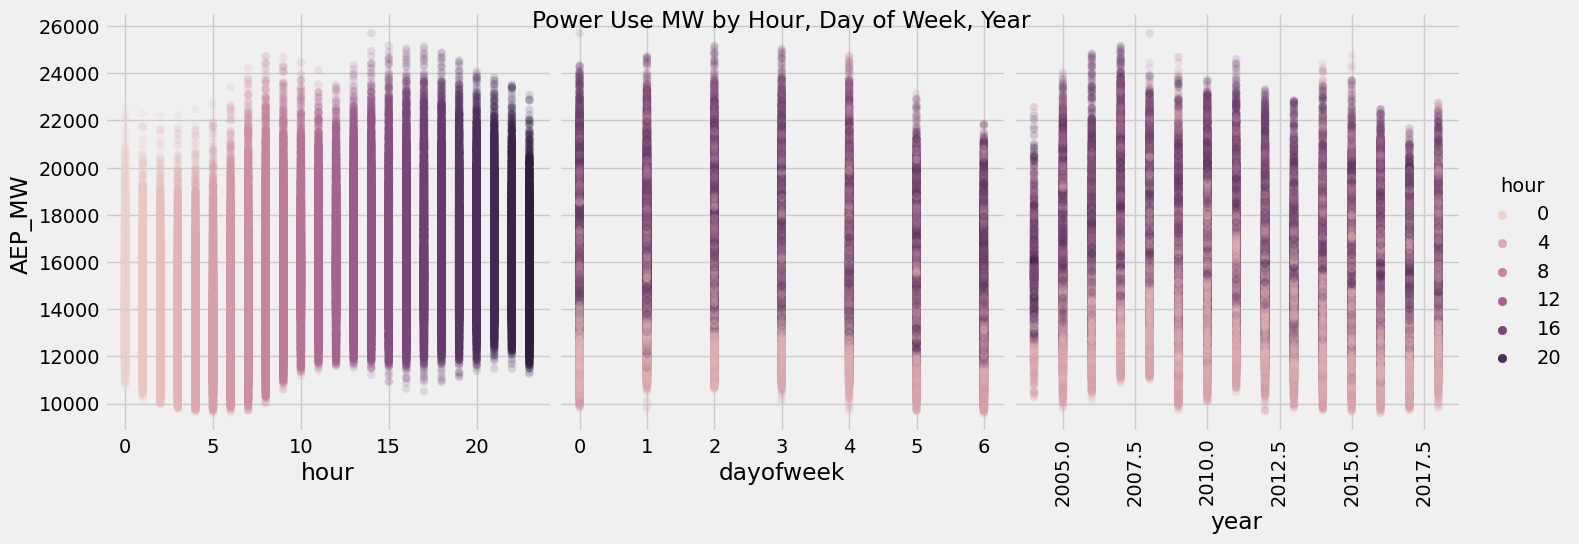

In [20]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year'],
             y_vars='AEP_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year')
plt.xticks(rotation=90)
plt.show()

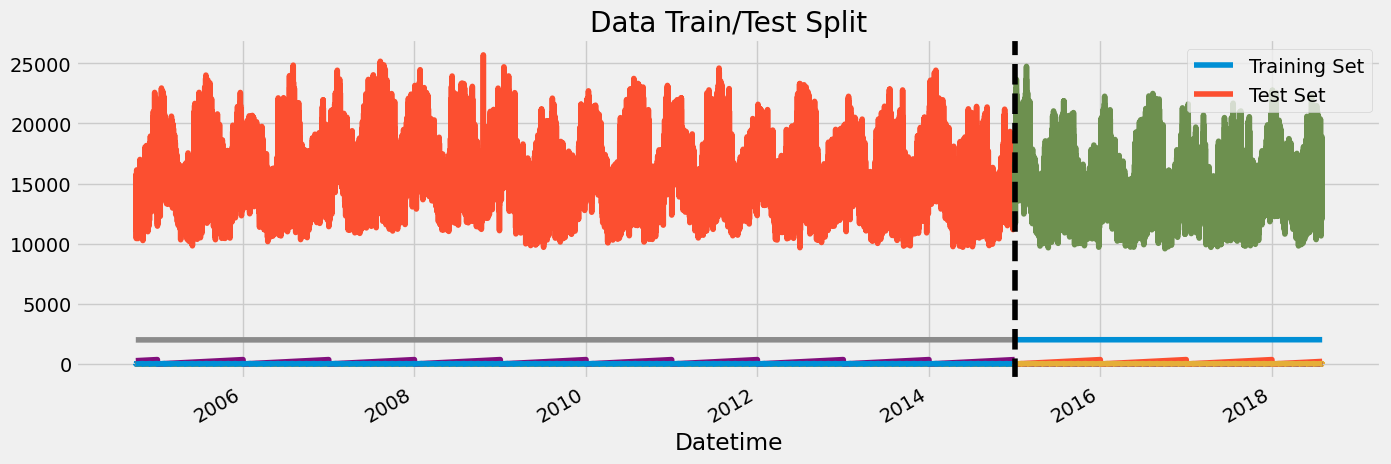

In [39]:
train = features_and_target.loc[features_and_target.index < '01-01-2015']
test = features_and_target.loc[features_and_target.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [40]:
train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,AEP_MW
Datetime,,,,,,,,
2004-12-31 01:00:00,1,4,4,12,2004,366,31,13478.0
2004-12-31 02:00:00,2,4,4,12,2004,366,31,12865.0
2004-12-31 03:00:00,3,4,4,12,2004,366,31,12577.0
2004-12-31 04:00:00,4,4,4,12,2004,366,31,12517.0
2004-12-31 05:00:00,5,4,4,12,2004,366,31,12670.0
...,...,...,...,...,...,...,...,...
2014-01-01 20:00:00,20,2,1,1,2014,1,1,16433.0
2014-01-01 21:00:00,21,2,1,1,2014,1,1,16376.0
2014-01-01 22:00:00,22,2,1,1,2014,1,1,16151.0


In [41]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [58]:
reg =xgb.XGBRegressor(n_estimators = 1000,early_stopping_rounds=50,learning_rate = 0.01)
reg.fit(x_train, y_train, 
       eval_set= [(x_train, y_train), (x_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:2557.05852	validation_1-rmse:2669.66874
[100]	validation_0-rmse:1667.99304	validation_1-rmse:1906.43321
[200]	validation_0-rmse:1388.41609	validation_1-rmse:1728.03964
[300]	validation_0-rmse:1260.06288	validation_1-rmse:1670.94367
[400]	validation_0-rmse:1170.54347	validation_1-rmse:1651.32523
[500]	validation_0-rmse:1113.48343	validation_1-rmse:1643.19503
[544]	validation_0-rmse:1091.83993	validation_1-rmse:1645.76653


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

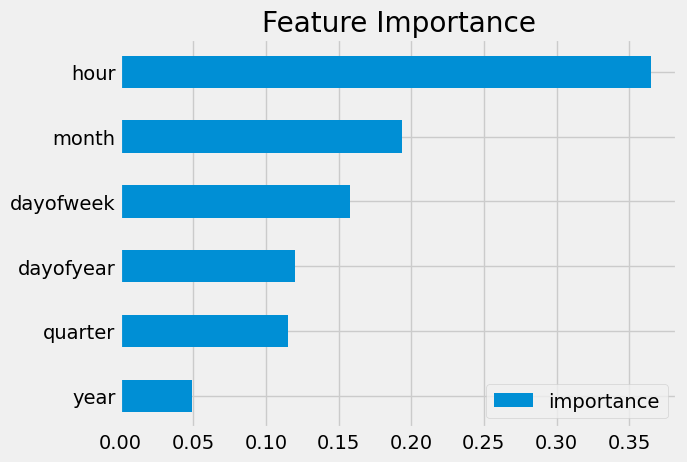

In [59]:
fi = pd.DataFrame(data=reg.feature_importances_,
                 index=reg.feature_names_in_,
                 columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

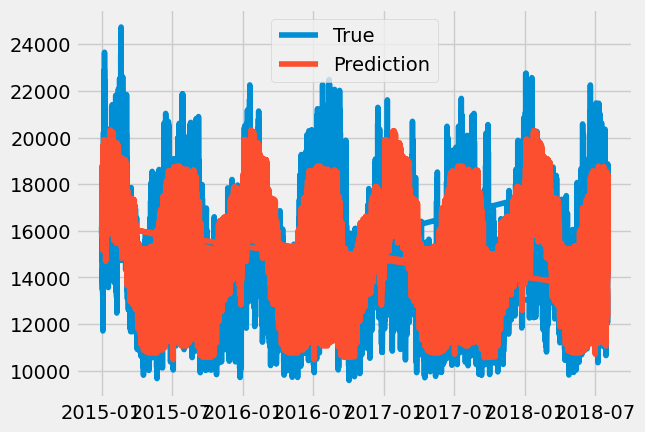

In [64]:
test['prediciton'] = reg.predict(x_test)

plt.plot(test['AEP_MW'],label='True')
plt.plot(test['prediciton'],label='Prediction')

plt.legend()

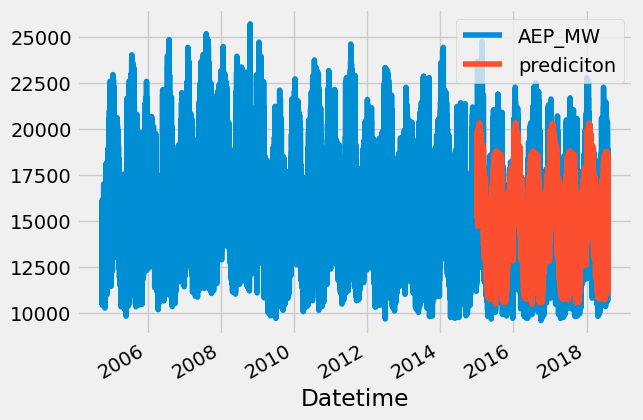

In [65]:
df['AEP_MW'].plot()
test['prediciton'].plot()
plt.legend()

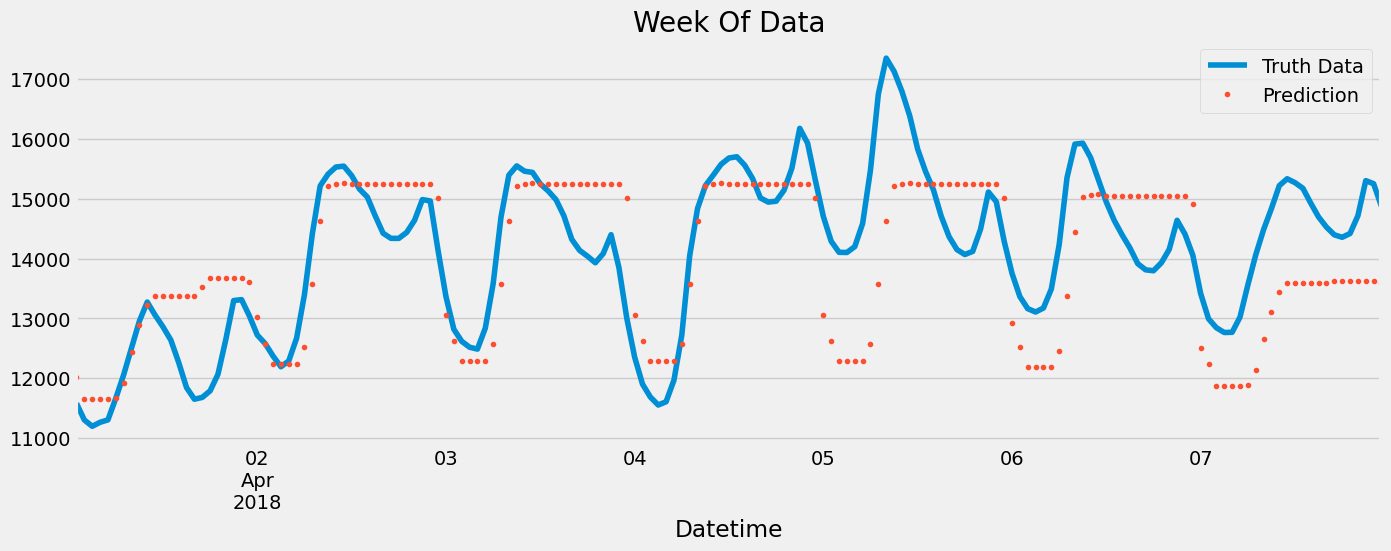

In [66]:
ax = features_and_target.loc[(features_and_target.index > '04-01-2018') & (features_and_target.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
features_and_target.loc[(features_and_target.index > '04-01-2018') & (features_and_target.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [67]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1643.09


In [68]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2017-01-22    4872.108968
2015-02-20    4861.401571
2015-02-19    4769.359985
2018-01-06    4403.549683
2017-02-07    4290.881022
2018-01-07    4202.593099
2017-01-03    4168.695475
2016-02-03    4092.213298
2017-01-23    4076.364746
2017-02-12    4060.571086
Name: error, dtype: float64